In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit

In [ ]:
# Load the FITS file
file_path = 'data/xyz_positions_and_oxygen_ao.fits'
with fits.open(file_path) as hdul:
    hdul.info()  # Gives an overview of the HDU structure
    data = hdul[1].data  # Usually the data is in the first extension

# Check the column names
print(data.columns.names)

Filename: data/xyz_positions_and_oxygen_ao.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (678,)   uint8   
  1  /Users/buder/Simulations/preparing_NIHAO/NIHAO_prepared/NIHAO_g8.26e    1 BinTableHDU     21   511520R x 4C   [E, E, E, D]   
['x', 'y', 'z', 'A_O']


In [ ]:
# Print column names in the FITS table
print(data.columns.names)

['x', 'y', 'z', 'A_O']


In [ ]:
# Extract positions and metallicity
x = data['x']
y = data['y']
z = data['z']
AO = data['A_O']  # Correct column name

# Compute cylindrical galactocentric radius
R_gal = np.sqrt(x**2 + y**2)

In [7]:
def linear_func(R, m, b):
    return m * R + b

In [ ]:
# Fit the linear function to the data
popt, pcov = curve_fit(linear_func, R_gal, AO)
slope, intercept = popt
slope_err, intercept_err = np.sqrt(np.diag(pcov))

print(f"Slope = {slope:.4f} ± {slope_err:.4f}")
print(f"Intercept = {intercept:.4f} ± {intercept_err:.4f}")

# Compute fitted values and residuals
AO_fit = linear_func(R_gal, slope, intercept)
residuals = AO - AO_fit

Slope = -0.0342 ± 0.0000
Intercept = 9.1278 ± 0.0002


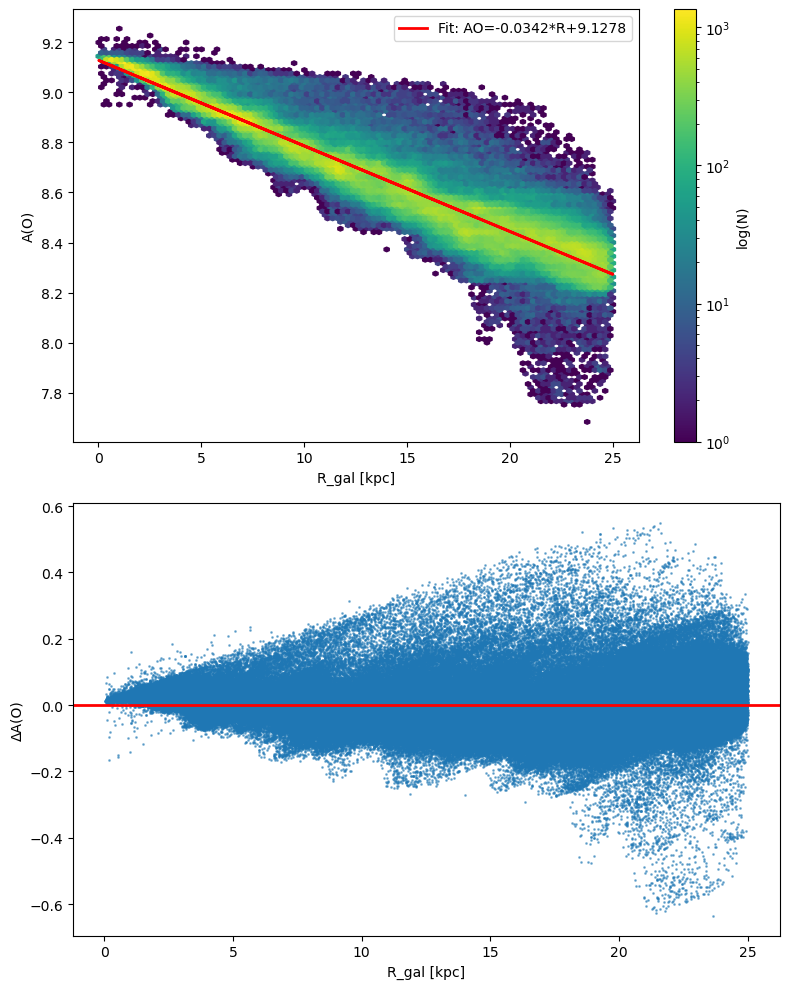

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Panel (a): Log-density plot of R_gal vs AO
hb = ax[0].hexbin(R_gal, AO, gridsize=100, cmap='viridis', bins='log')
ax[0].plot(R_gal, AO_fit, color='red', lw=2, label=f'Fit: AO={slope:.4f}*R+{intercept:.4f}')
ax[0].set_xlabel('R_gal [kpc]')
ax[0].set_ylabel('A(O)')
ax[0].legend()
fig.colorbar(hb, ax=ax[0], label='log(N)')

# Panel (b): Residuals
ax[1].scatter(R_gal, residuals, s=1, alpha=0.5)
ax[1].axhline(0, color='red', lw=2)
ax[1].set_xlabel('R_gal [kpc]')
ax[1].set_ylabel('ΔA(O)')

plt.tight_layout()
plt.savefig('figures/RGal_vs_AO_fit_and_residuals.png')
plt.show()


In [ ]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean(residuals**2))
print(f"RMSE = {rmse:.4f}")

RMSE = 0.0726


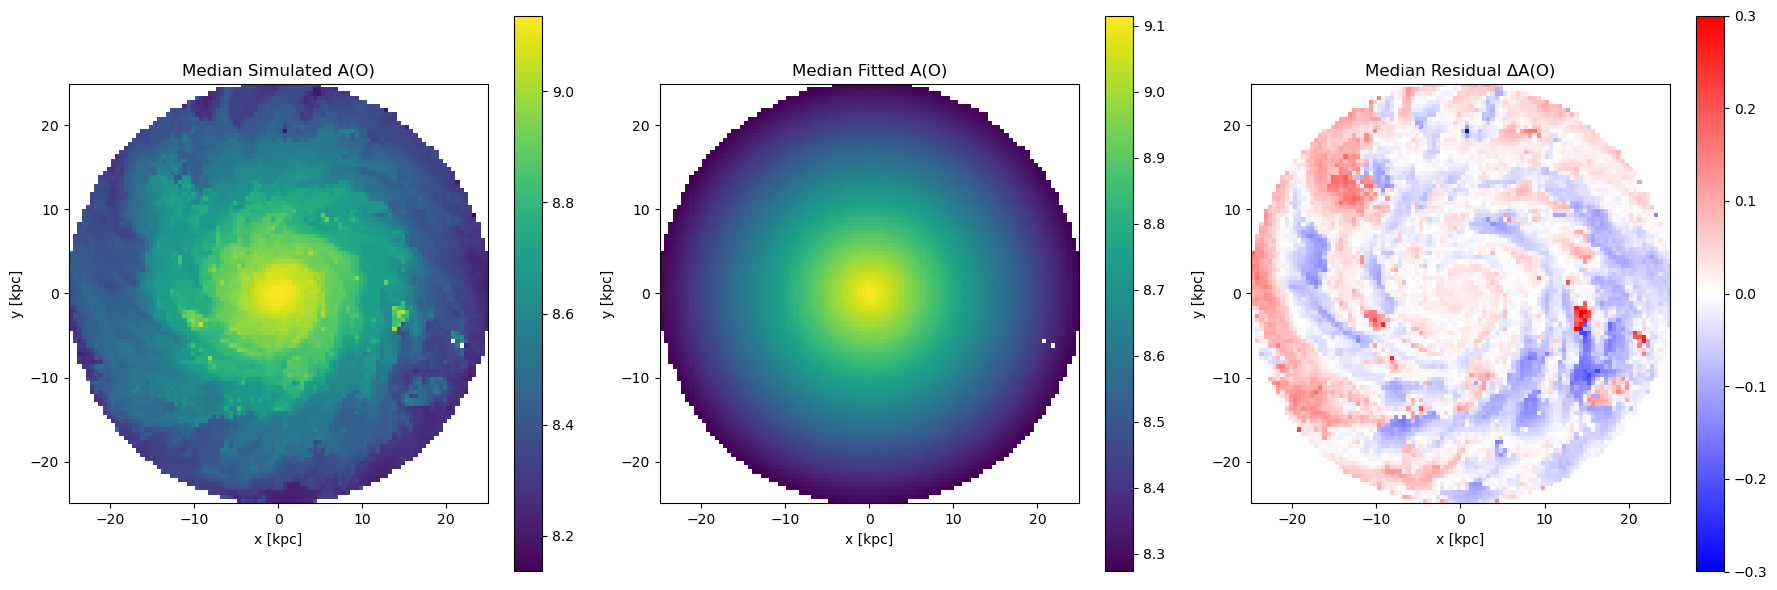

In [ ]:
# Define bins for x-y plane
nbins = 100
x_edges = np.linspace(x.min(), x.max(), nbins+1)
y_edges = np.linspace(y.min(), y.max(), nbins+1)

# Compute 2D median maps
AO_median_map = np.zeros((nbins, nbins))
AO_fit_map = np.zeros((nbins, nbins))
residual_map = np.zeros((nbins, nbins))

for i in range(nbins):
    for j in range(nbins):
        mask = (x >= x_edges[i]) & (x < x_edges[i+1]) & (y >= y_edges[j]) & (y < y_edges[j+1])
        if np.any(mask):
            AO_median_map[j,i] = np.median(AO[mask])
            AO_fit_map[j,i] = np.median(AO_fit[mask])
            residual_map[j,i] = np.median(residuals[mask])
        else:
            AO_median_map[j,i] = np.nan
            AO_fit_map[j,i] = np.nan
            residual_map[j,i] = np.nan

# Plot 3-panel figure
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

im0 = ax[0].imshow(AO_median_map, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()],
                   cmap='viridis', aspect='equal')
ax[0].set_title('Median Simulated A(O)')
fig.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(AO_fit_map, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()],
                   cmap='viridis', aspect='equal')
ax[1].set_title('Median Fitted A(O)')
fig.colorbar(im1, ax=ax[1])

im2 = ax[2].imshow(residual_map, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()],
                   cmap='bwr', aspect='equal', vmin=-0.3, vmax=0.3)
ax[2].set_title('Median Residual ΔA(O)')
fig.colorbar(im2, ax=ax[2])

for a in ax:
    a.set_xlabel('x [kpc]')
    a.set_ylabel('y [kpc]')

plt.tight_layout()
plt.savefig('figures/xy_median_maps.png')
plt.show()

In [ ]:
'''
Bins: 100x100 gives good spatial resolution. Fewer bins → lose details, more bins → noisy or empty cells.

Colormap: 'bwr' for residuals clearly shows over- and under-predicted regions.

Analysis: You will likely see negative residuals in inner regions and positive residuals in outer spiral arms or low-density regions, indicating local deviations from the simple linear gradient.'''